In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split


from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Fragments
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdFMCS
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, global_max_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /u/shaswata/.local/lib/python3.9/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN5torch8autograd13_wrap_outputsERKSt6vectorIN2at6TensorESaIS3_EERKSt13unordered_setIPN3c1010TensorImplESt4hashISB_ESt8equal_toISB_ESaISB_EESJ_NS9_8ArrayRefINS9_8optionalIS3_EEEERKSt10shared_ptrINS0_4NodeEESt8functionIFS5_S5_S5_EE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /u/shaswata/.local/lib/python3.9/site-packages/torch_cluster/_graclus_cpu.so: undefined symbol: _ZN2at4_ops8randperm4callElN3c108optionalINS2_10ScalarTypeEEENS3_INS2_6LayoutEEENS3_INS2_6DeviceEEENS3_IbEE
  warnings.warn(f"An issue occurred while importi

Using device: cuda


In [2]:
df = pd.read_csv('/u/shaswata/scratch/Learning/xAI_Drug/tox21.csv')
    
df = df.dropna(subset=['NR-AhR', 'smiles'])

In [3]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic()),
            atom.GetNumRadicalElectrons(),
            atom.GetTotalNumHs()
        ]
        atom_features.append(features)
    
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.extend([[i, j], [j, i]]) 
        
        bond_features = [
            int(bond.GetBondType()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        edge_features.extend([bond_features, bond_features])
    
    x = torch.tensor(atom_features, dtype=torch.float)
    
    if edge_indices:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)  
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [4]:
graphs = []
labels = []
valid_smiles = []

for idx, row in df.iterrows():
    smiles = row['smiles']
    label = int(row['NR-AhR'])
    
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs.append(graph)
        labels.append(label)
        valid_smiles.append(smiles)

for i, graph in enumerate(graphs):
    graph.y = torch.tensor([labels[i]], dtype=torch.long)

train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42, 
                                           stratify=labels)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

[13:14:59] WARNING: not removing hydrogen atom without neighbors
[13:14:59] Explicit valence for atom # 3 Al, 6, is greater than permitted
[13:14:59] Explicit valence for atom # 4 Al, 6, is greater than permitted
[13:15:00] Explicit valence for atom # 4 Al, 6, is greater than permitted
[13:14:59] Explicit valence for atom # 3 Al, 6, is greater than permitted
[13:14:59] Explicit valence for atom # 4 Al, 6, is greater than permitted
[13:15:00] Explicit valence for atom # 4 Al, 6, is greater than permitted
[13:15:00] Explicit valence for atom # 9 Al, 6, is greater than permitted
[13:15:00] Explicit valence for atom # 5 Al, 6, is greater than permitted
[13:15:01] Explicit valence for atom # 16 Al, 6, is greater than permitted
[13:15:00] Explicit valence for atom # 9 Al, 6, is greater than permitted
[13:15:00] Explicit valence for atom # 5 Al, 6, is greater than permitted
[13:15:01] Explicit valence for atom # 16 Al, 6, is greater than permitted
[13:15:01] Explicit valence for atom # 20 Al,

In [8]:
class MPNNLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super(MPNNLayer, self).__init__(aggr='add')
        
        # Message function
        self.message_net = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.update_net = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim)
        )
    
    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)
    
    def message(self, x_i, x_j, edge_attr):
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=1)
        return self.message_net(msg_input)
    
    def update(self, aggr_out, x):
        update_input = torch.cat([x, aggr_out], dim=1)
        return self.update_net(update_input)
    
class MPNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, num_layers=3, num_classes=2):
        super(MPNNModel, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        # Input projection
        self.node_embedding = nn.Linear(node_dim, hidden_dim)
        
        # MPNN layers
        self.mpnn_layers = nn.ModuleList([
            MPNNLayer(hidden_dim, edge_dim, hidden_dim) 
            for _ in range(num_layers)
        ])
        
        # Output layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # *2 for mean and max pooling
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x, edge_index=None, edge_attr=None, batch=None):
        # Handle both data object and individual arguments
        if hasattr(x, 'x'):  # x is actually a data object
            data = x
            x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Initial node embedding
        x = self.node_embedding(x)
        
        # Apply MPNN layers only if there are edges
        if edge_index.size(1) > 0:
            for layer in self.mpnn_layers:
                x = layer(x, edge_index, edge_attr)
                x = F.relu(x)
        # If no edges, just apply activation to embedded features
        else:
            x = F.relu(x)
        
        # Graph-level representation
        graph_mean = global_mean_pool(x, batch)
        graph_max = global_max_pool(x, batch)
        graph_repr = torch.cat([graph_mean, graph_max], dim=1)
        
        # Classification
        out = self.classifier(graph_repr)
        return out

# Initialize model
node_dim = 7  # Number of atom features
edge_dim = 3  # Number of bond features
hidden_dim = 64

model = MPNNModel(node_dim, edge_dim, hidden_dim).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Model initialized with 85986 parameters


/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Loss: 0.3854 	 Train Acc: 0.8827 	 Test Acc: 0.8824
Loss: 0.2955 	 Train Acc: 0.8834 	 Test Acc: 0.8862
Loss: 0.2955 	 Train Acc: 0.8834 	 Test Acc: 0.8862
Loss: 0.2570 	 Train Acc: 0.8938 	 Test Acc: 0.8953
Loss: 0.2570 	 Train Acc: 0.8938 	 Test Acc: 0.8953
Loss: 0.2411 	 Train Acc: 0.8993 	 Test Acc: 0.8992
Loss: 0.2411 	 Train Acc: 0.8993 	 Test Acc: 0.8992
Loss: 0.2196 	 Train Acc: 0.9111 	 Test Acc: 0.8930
Loss: 0.2196 	 Train Acc: 0.9111 	 Test Acc: 0.8930
Loss: 0.2042 	 Train Acc: 0.9178 	 Test Acc: 0.8984
Loss: 0.2042 	 Train Acc: 0.9178 	 Test Acc: 0.8984
Loss: 0.1862 	 Train Acc: 0.9306 	 Test Acc: 0.8961
Loss: 0.1862 	 Train Acc: 0.9306 	 Test Acc: 0.8961
Loss: 0.1796 	 Train Acc: 0.9337 	 Test Acc: 0.8923
Loss: 0.1796 	 Train Acc: 0.9337 	 Test Acc: 0.8923
Loss: 0.1663 	 Train Acc: 0.9404 	 Test Acc: 0.8923
Loss: 0.1663 	 Train Acc: 0.9404 	 Test Acc: 0.8923
Loss: 0.1637 	 Train Acc: 0.9442 	 Test Acc: 0.8930
Loss: 0.1637 	 Train Acc: 0.9442 	 Test Acc: 0.8930
Loss: 0.1539

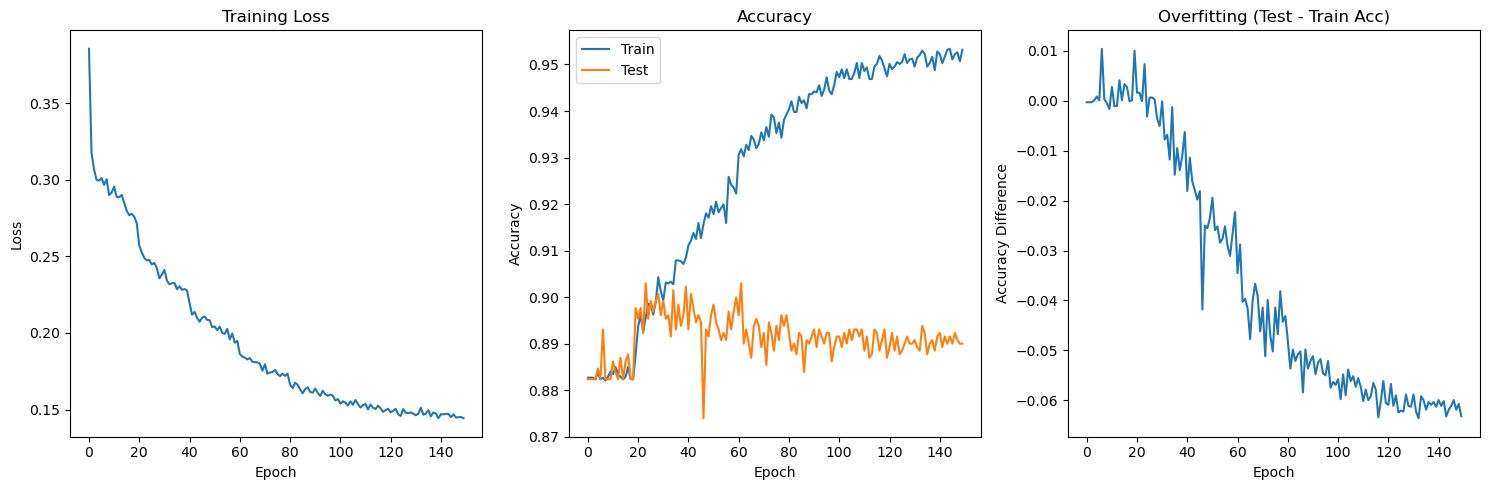

In [6]:
def train_model(model, train_loader, test_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch)
                pred = out.argmax(dim=1)
                test_correct += (pred == batch.y).sum().item()
                test_total += batch.y.size(0)
        
        test_acc = test_correct / test_total
        
        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        scheduler.step()
        
        if epoch % 10 == 0:
            print(f'Loss: {avg_loss:.4f} \t Train Acc: {train_acc:.4f} \t Test Acc: {test_acc:.4f}')
    
    return train_losses, train_accs, test_accs

train_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, num_epochs=150)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.array(test_accs) - np.array(train_accs))
plt.title('Overfitting (Test - Train Acc)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Difference')

plt.tight_layout()
plt.show()

In [9]:
# Extract molecular properties for concept whitening
from rdkit.Chem import QED, Crippen, rdMolDescriptors, Descriptors

def extract_molecular_properties(smiles):
    """Extract specified molecular properties from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    properties = {
        'qed': QED.qed(mol),
        'tpsa': rdMolDescriptors.CalcTPSA(mol),
        'logp': Crippen.MolLogP(mol),
        'NOCount': rdMolDescriptors.CalcNumLipinskiHBD(mol) + rdMolDescriptors.CalcNumLipinskiHBA(mol),
        'n_heteroatoms': rdMolDescriptors.CalcNumHeteroatoms(mol)
    }
    return properties

# Extract properties for all valid molecules
print("Extracting molecular properties...")
molecular_properties = []
aligned_smiles = []
aligned_labels = []

for i, (graph, smiles) in enumerate(zip(graphs, valid_smiles)):
    props = extract_molecular_properties(smiles)
    if props is not None:
        molecular_properties.append(props)
        aligned_smiles.append(smiles)
        aligned_labels.append(labels[i])

print(f"Successfully extracted properties for {len(molecular_properties)} molecules")

# Convert to numpy array for easier manipulation
property_names = ['qed', 'tpsa', 'logp', 'NOCount', 'n_heteroatoms']
property_matrix = np.array([[props[name] for name in property_names] for props in molecular_properties])

print("Property statistics:")
for i, name in enumerate(property_names):
    print(f"{name}: mean={property_matrix[:, i].mean():.3f}, std={property_matrix[:, i].std():.3f}")

Extracting molecular properties...


[13:25:30] WARNING: not removing hydrogen atom without neighbors
[13:25:30] WARNING: not removing hydrogen atom without neighbors


Successfully extracted properties for 6542 molecules
Property statistics:
qed: mean=0.542, std=0.187
tpsa: mean=57.951, std=58.162
logp: mean=2.325, std=2.295
NOCount: mean=5.333, std=5.528
n_heteroatoms: mean=4.835, std=4.064


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

class GraphConceptWhitener:
    def __init__(self, model, property_matrix, property_names):
        self.model = model
        self.property_matrix = property_matrix
        self.property_names = property_names
        self.scaler = StandardScaler()
        self.normalized_properties = self.scaler.fit_transform(property_matrix)
        
    def get_layer_activations(self, data_loader):
        """Extract activations from each layer of the model"""
        self.model.eval()
        layer_activations = {
            'node_embedding': [],
            'layer_0': [],
            'layer_1': [],
            'layer_2': [],
            'final_representation': []
        }
        
        with torch.no_grad():
            for batch in data_loader:
                batch = batch.to(device)
                x = batch.x
                edge_index = batch.edge_index
                edge_attr = batch.edge_attr
                batch_idx = batch.batch
                
                # Node embedding
                x_embedded = self.model.node_embedding(x)
                layer_activations['node_embedding'].append(
                    global_mean_pool(x_embedded, batch_idx).cpu().numpy()
                )
                
                # MPNN layers
                x_current = x_embedded
                for i, layer in enumerate(self.model.mpnn_layers):
                    if edge_index.size(1) > 0:
                        x_current = layer(x_current, edge_index, edge_attr)
                        x_current = F.relu(x_current)
                    else:
                        x_current = F.relu(x_current)
                    
                    layer_activations[f'layer_{i}'].append(
                        global_mean_pool(x_current, batch_idx).cpu().numpy()
                    )
                
                # Final representation (before classification)
                graph_mean = global_mean_pool(x_current, batch_idx)
                graph_max = global_max_pool(x_current, batch_idx)
                final_repr = torch.cat([graph_mean, graph_max], dim=1)
                layer_activations['final_representation'].append(final_repr.cpu().numpy())
        
        # Concatenate all batches
        for layer_name in layer_activations:
            layer_activations[layer_name] = np.vstack(layer_activations[layer_name])
            
        return layer_activations
    
    def compute_concept_importance(self, layer_activations):
        """Compute importance of each molecular property for each layer"""
        concept_importance = {}
        
        for layer_name, activations in layer_activations.items():
            print(f"Computing concept importance for {layer_name}...")
            
            # Ensure we have the same number of samples
            min_samples = min(len(activations), len(self.normalized_properties))
            layer_activations_subset = activations[:min_samples]
            properties_subset = self.normalized_properties[:min_samples]
            
            # For each activation dimension, compute how well it can be predicted by properties
            importance_scores = []
            
            for dim in range(layer_activations_subset.shape[1]):
                activation_dim = layer_activations_subset[:, dim]
                
                # Fit linear regression to predict this activation dimension from properties
                reg = LinearRegression()
                reg.fit(properties_subset, activation_dim)
                
                # R² score indicates how much variance in activations is explained by properties
                r2_score = reg.score(properties_subset, activation_dim)
                
                # Individual feature importance (absolute coefficients)
                feature_importance = np.abs(reg.coef_)
                importance_scores.append(feature_importance)
            
            # Average importance across all activation dimensions
            avg_importance = np.mean(importance_scores, axis=0)
            concept_importance[layer_name] = dict(zip(self.property_names, avg_importance))
            
        return concept_importance

# Create aligned dataset for concept whitening
print("Creating aligned dataset...")
aligned_graphs = []
for i, smiles in enumerate(aligned_smiles):
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graph.y = torch.tensor([aligned_labels[i]], dtype=torch.long)
        aligned_graphs.append(graph)

# Create data loader for aligned data
aligned_loader = DataLoader(aligned_graphs, batch_size=32, shuffle=False)

print(f"Aligned dataset size: {len(aligned_graphs)}")
print(f"Property matrix shape: {property_matrix.shape}")

# Initialize concept whitener
concept_whitener = GraphConceptWhitener(model, property_matrix, property_names)

Creating aligned dataset...


[13:25:39] WARNING: not removing hydrogen atom without neighbors


Aligned dataset size: 6542
Property matrix shape: (6542, 5)


Extracting layer activations...
Computing concept importance...
Computing concept importance for node_embedding...
Computing concept importance for layer_0...
Computing concept importance for layer_1...
Computing concept importance for layer_2...
Computing concept importance...
Computing concept importance for node_embedding...
Computing concept importance for layer_0...
Computing concept importance for layer_1...
Computing concept importance for layer_2...
Computing concept importance for final_representation...

Concept Importance Results:

node_embedding:
  qed: 0.0761
  tpsa: 0.2409
  logp: 0.1214
  NOCount: 0.2057
  n_heteroatoms: 0.3091

layer_0:
  qed: 0.0071
  tpsa: 0.0208
  logp: 0.0079
  NOCount: 0.0126
  n_heteroatoms: 0.0209

layer_1:
  qed: 0.0035
  tpsa: 0.0025
  logp: 0.0021
  NOCount: 0.0018
  n_heteroatoms: 0.0019

layer_2:
  qed: 0.0047
  tpsa: 0.0028
  logp: 0.0028
  NOCount: 0.0016
  n_heteroatoms: 0.0015

final_representation:
  qed: 0.0063
  tpsa: 0.0031
  logp: 0

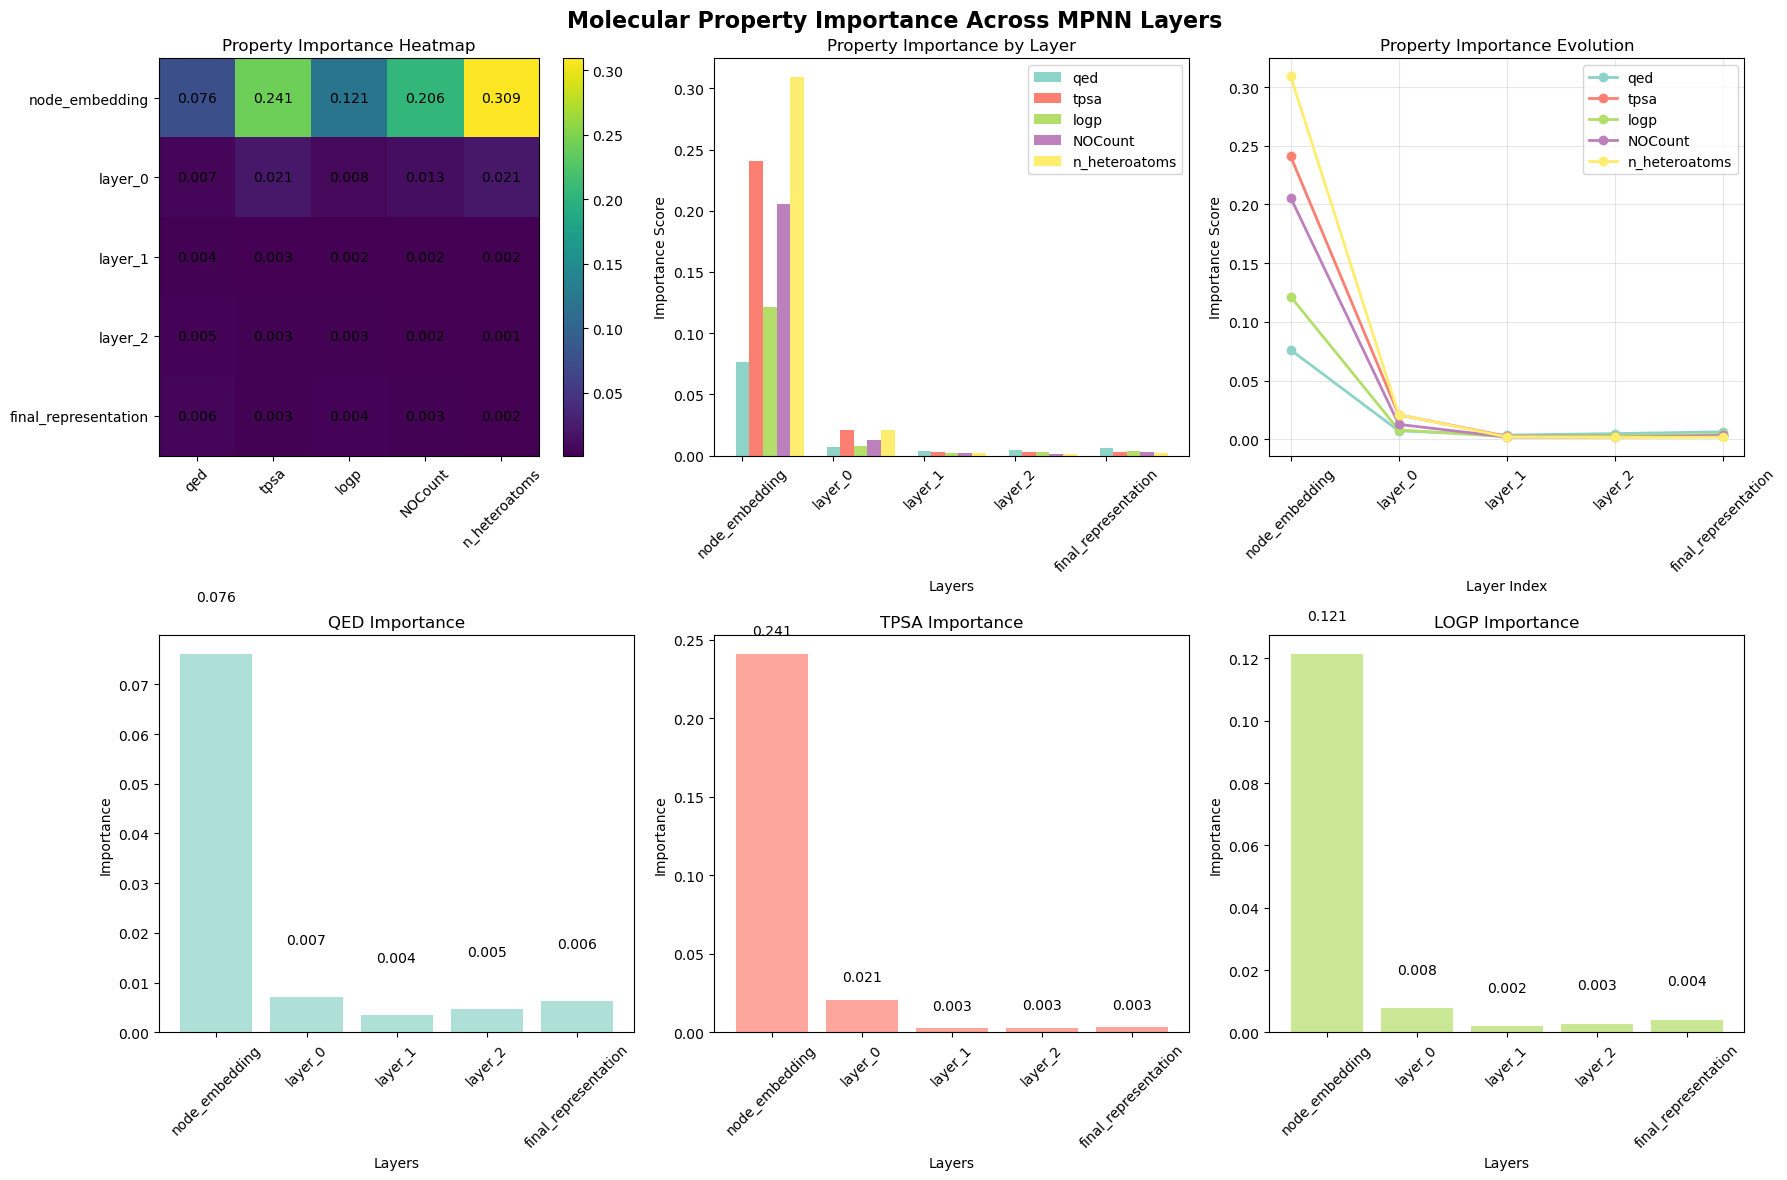


Summary Statistics:
Most important property overall: n_heteroatoms
Least important property overall: qed
Layer with highest average importance: node_embedding
Layer with lowest average importance: layer_1

Property ranking by average importance:
1. n_heteroatoms: 0.0670
2. tpsa: 0.0540
3. NOCount: 0.0450
4. logp: 0.0277
5. qed: 0.0195


In [12]:
# Compute layer activations and concept importance
print("Extracting layer activations...")
layer_activations = concept_whitener.get_layer_activations(aligned_loader)

print("Computing concept importance...")
concept_importance = concept_whitener.compute_concept_importance(layer_activations)

# Display results
print("\nConcept Importance Results:")
print("=" * 50)
for layer_name, importance_dict in concept_importance.items():
    print(f"\n{layer_name}:")
    for prop_name, importance in importance_dict.items():
        print(f"  {prop_name}: {importance:.4f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Molecular Property Importance Across MPNN Layers', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# 1. Heatmap of all importances
importance_matrix = np.array([[importance_dict[prop] for prop in property_names] 
                             for layer_name, importance_dict in concept_importance.items()])
layer_names = list(concept_importance.keys())

im1 = axes_flat[0].imshow(importance_matrix, cmap='viridis', aspect='auto')
axes_flat[0].set_xticks(range(len(property_names)))
axes_flat[0].set_xticklabels(property_names, rotation=45)
axes_flat[0].set_yticks(range(len(layer_names)))
axes_flat[0].set_yticklabels(layer_names)
axes_flat[0].set_title('Property Importance Heatmap')
plt.colorbar(im1, ax=axes_flat[0])

# Add values to heatmap
for i in range(len(layer_names)):
    for j in range(len(property_names)):
        axes_flat[0].text(j, i, f'{importance_matrix[i, j]:.3f}', 
                         ha='center', va='center', color='white' if importance_matrix[i, j] > 0.5 else 'black')

# 2. Bar plot for each property across layers
colors = plt.cm.Set3(np.linspace(0, 1, len(property_names)))
for i, prop_name in enumerate(property_names):
    prop_importance = [concept_importance[layer][prop_name] for layer in layer_names]
    axes_flat[1].bar([j + i*0.15 for j in range(len(layer_names))], prop_importance, 
                    width=0.15, label=prop_name, color=colors[i])

axes_flat[1].set_xlabel('Layers')
axes_flat[1].set_ylabel('Importance Score')
axes_flat[1].set_title('Property Importance by Layer')
axes_flat[1].set_xticks(range(len(layer_names)))
axes_flat[1].set_xticklabels(layer_names, rotation=45)
axes_flat[1].legend()

# 3. Line plot showing evolution of each property across layers
for i, prop_name in enumerate(property_names):
    prop_importance = [concept_importance[layer][prop_name] for layer in layer_names]
    axes_flat[2].plot(range(len(layer_names)), prop_importance, 
                     marker='o', label=prop_name, color=colors[i], linewidth=2)

axes_flat[2].set_xlabel('Layer Index')
axes_flat[2].set_ylabel('Importance Score')
axes_flat[2].set_title('Property Importance Evolution')
axes_flat[2].set_xticks(range(len(layer_names)))
axes_flat[2].set_xticklabels(layer_names, rotation=45)
axes_flat[2].legend()
axes_flat[2].grid(True, alpha=0.3)

# 4. Individual property plots
for i, prop_name in enumerate(property_names[:3]):  # Show first 3 properties
    prop_importance = [concept_importance[layer][prop_name] for layer in layer_names]
    axes_flat[3+i].bar(range(len(layer_names)), prop_importance, color=colors[i], alpha=0.7)
    axes_flat[3+i].set_title(f'{prop_name.upper()} Importance')
    axes_flat[3+i].set_xlabel('Layers')
    axes_flat[3+i].set_ylabel('Importance')
    axes_flat[3+i].set_xticks(range(len(layer_names)))
    axes_flat[3+i].set_xticklabels(layer_names, rotation=45)
    
    # Add value labels on bars
    for j, v in enumerate(prop_importance):
        axes_flat[3+i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print("=" * 50)
print(f"Most important property overall: {property_names[np.argmax(np.mean(importance_matrix, axis=0))]}")
print(f"Least important property overall: {property_names[np.argmin(np.mean(importance_matrix, axis=0))]}")
print(f"Layer with highest average importance: {layer_names[np.argmax(np.mean(importance_matrix, axis=1))]}")
print(f"Layer with lowest average importance: {layer_names[np.argmin(np.mean(importance_matrix, axis=1))]}")

# Property ranking by average importance
avg_importance = np.mean(importance_matrix, axis=0)
property_ranking = sorted(zip(property_names, avg_importance), key=lambda x: x[1], reverse=True)
print(f"\nProperty ranking by average importance:")
for i, (prop, importance) in enumerate(property_ranking, 1):
    print(f"{i}. {prop}: {importance:.4f}")

Extracting MPNN layer activations...
Computing concept importance for MPNN layers...
Computing concept importance for layer_0...
Computing concept importance for layer_1...
Computing concept importance for layer_2...

MPNN Layer Concept Importance Results:

layer_0:
  qed: 0.0071
  tpsa: 0.0208
  logp: 0.0079
  NOCount: 0.0126
  n_heteroatoms: 0.0209

layer_1:
  qed: 0.0035
  tpsa: 0.0025
  logp: 0.0021
  NOCount: 0.0018
  n_heteroatoms: 0.0019

layer_2:
  qed: 0.0047
  tpsa: 0.0028
  logp: 0.0028
  NOCount: 0.0016
  n_heteroatoms: 0.0015
Computing concept importance for MPNN layers...
Computing concept importance for layer_0...
Computing concept importance for layer_1...
Computing concept importance for layer_2...

MPNN Layer Concept Importance Results:

layer_0:
  qed: 0.0071
  tpsa: 0.0208
  logp: 0.0079
  NOCount: 0.0126
  n_heteroatoms: 0.0209

layer_1:
  qed: 0.0035
  tpsa: 0.0025
  logp: 0.0021
  NOCount: 0.0018
  n_heteroatoms: 0.0019

layer_2:
  qed: 0.0047
  tpsa: 0.0028
  lo

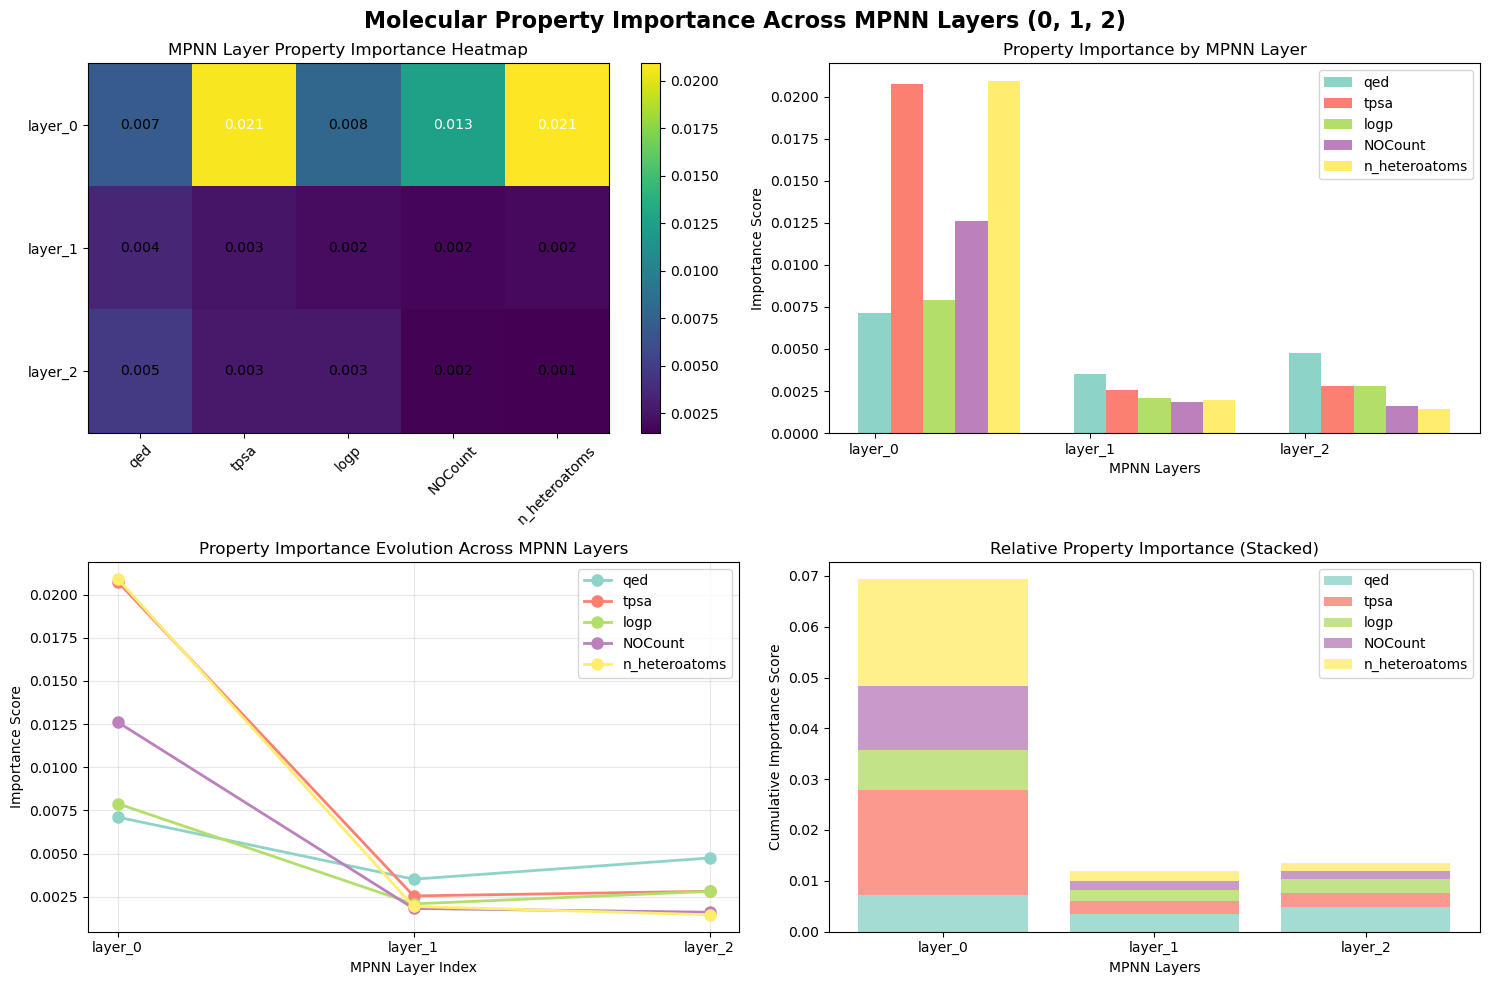


MPNN Layer Summary Statistics:
Most important property across MPNN layers: tpsa
Least important property across MPNN layers: logp
MPNN layer with highest average importance: layer_0
MPNN layer with lowest average importance: layer_1

Property ranking by average importance across MPNN layers:
1. tpsa: 0.0087
2. n_heteroatoms: 0.0081
3. NOCount: 0.0053
4. qed: 0.0051
5. logp: 0.0043

Importance change from Layer 0 to Layer 2:
qed: 0.0071 → 0.0047 (change: -0.0024, -33.3%)
tpsa: 0.0208 → 0.0028 (change: -0.0179, -86.4%)
logp: 0.0079 → 0.0028 (change: -0.0051, -64.4%)
NOCount: 0.0126 → 0.0016 (change: -0.0110, -87.3%)
n_heteroatoms: 0.0209 → 0.0015 (change: -0.0195, -93.1%)


In [14]:
# Modified Concept Whitener - Focus on MPNN Layers Only
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

class SimplifiedGraphConceptWhitener:
    def __init__(self, model, property_matrix, property_names):
        self.model = model
        self.property_matrix = property_matrix
        self.property_names = property_names
        self.scaler = StandardScaler()
        self.normalized_properties = self.scaler.fit_transform(property_matrix)
        
    def get_mpnn_layer_activations(self, data_loader):
        """Extract activations from MPNN layers only (0, 1, 2)"""
        self.model.eval()
        layer_activations = {
            'layer_0': [],
            'layer_1': [],
            'layer_2': []
        }
        
        with torch.no_grad():
            for batch in data_loader:
                batch = batch.to(device)
                x = batch.x
                edge_index = batch.edge_index
                edge_attr = batch.edge_attr
                batch_idx = batch.batch
                
                # Start with node embedding (but don't store it)
                x_current = self.model.node_embedding(x)
                
                # MPNN layers - store activations for layers 0, 1, 2
                for i, layer in enumerate(self.model.mpnn_layers):
                    if edge_index.size(1) > 0:
                        x_current = layer(x_current, edge_index, edge_attr)
                        x_current = F.relu(x_current)
                    else:
                        x_current = F.relu(x_current)
                    
                    # Store activation for this layer
                    layer_activations[f'layer_{i}'].append(
                        global_mean_pool(x_current, batch_idx).cpu().numpy()
                    )
        
        # Concatenate all batches
        for layer_name in layer_activations:
            layer_activations[layer_name] = np.vstack(layer_activations[layer_name])
            
        return layer_activations
    
    def compute_concept_importance(self, layer_activations):
        """Compute importance of each molecular property for each MPNN layer"""
        concept_importance = {}
        
        for layer_name, activations in layer_activations.items():
            print(f"Computing concept importance for {layer_name}...")
            
            # Ensure we have the same number of samples
            min_samples = min(len(activations), len(self.normalized_properties))
            layer_activations_subset = activations[:min_samples]
            properties_subset = self.normalized_properties[:min_samples]
            
            # For each activation dimension, compute how well it can be predicted by properties
            importance_scores = []
            
            for dim in range(layer_activations_subset.shape[1]):
                activation_dim = layer_activations_subset[:, dim]
                
                # Fit linear regression to predict this activation dimension from properties
                reg = LinearRegression()
                reg.fit(properties_subset, activation_dim)
                
                # Individual feature importance (absolute coefficients)
                feature_importance = np.abs(reg.coef_)
                importance_scores.append(feature_importance)
            
            # Average importance across all activation dimensions
            avg_importance = np.mean(importance_scores, axis=0)
            concept_importance[layer_name] = dict(zip(self.property_names, avg_importance))
            
        return concept_importance

# Initialize simplified concept whitener
simplified_whitener = SimplifiedGraphConceptWhitener(model, property_matrix, property_names)

# Extract MPNN layer activations
print("Extracting MPNN layer activations...")
mpnn_activations = simplified_whitener.get_mpnn_layer_activations(aligned_loader)

print("Computing concept importance for MPNN layers...")
mpnn_importance = simplified_whitener.compute_concept_importance(mpnn_activations)

# Display results
print("\nMPNN Layer Concept Importance Results:")
print("=" * 50)
for layer_name, importance_dict in mpnn_importance.items():
    print(f"\n{layer_name}:")
    for prop_name, importance in importance_dict.items():
        print(f"  {prop_name}: {importance:.4f}")

# Create focused visualization for MPNN layers only
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Molecular Property Importance Across MPNN Layers (0, 1, 2)', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# 1. Heatmap of MPNN layer importances
mpnn_importance_matrix = np.array([[importance_dict[prop] for prop in property_names] 
                                  for layer_name, importance_dict in mpnn_importance.items()])
mpnn_layer_names = list(mpnn_importance.keys())

im1 = axes_flat[0].imshow(mpnn_importance_matrix, cmap='viridis', aspect='auto')
axes_flat[0].set_xticks(range(len(property_names)))
axes_flat[0].set_xticklabels(property_names, rotation=45)
axes_flat[0].set_yticks(range(len(mpnn_layer_names)))
axes_flat[0].set_yticklabels(mpnn_layer_names)
axes_flat[0].set_title('MPNN Layer Property Importance Heatmap')
plt.colorbar(im1, ax=axes_flat[0])

# Add values to heatmap
for i in range(len(mpnn_layer_names)):
    for j in range(len(property_names)):
        axes_flat[0].text(j, i, f'{mpnn_importance_matrix[i, j]:.3f}', 
                         ha='center', va='center', 
                         color='white' if mpnn_importance_matrix[i, j] > np.max(mpnn_importance_matrix)/2 else 'black')

# 2. Bar plot for each property across MPNN layers
colors = plt.cm.Set3(np.linspace(0, 1, len(property_names)))
for i, prop_name in enumerate(property_names):
    prop_importance = [mpnn_importance[layer][prop_name] for layer in mpnn_layer_names]
    axes_flat[1].bar([j + i*0.15 for j in range(len(mpnn_layer_names))], prop_importance, 
                    width=0.15, label=prop_name, color=colors[i])

axes_flat[1].set_xlabel('MPNN Layers')
axes_flat[1].set_ylabel('Importance Score')
axes_flat[1].set_title('Property Importance by MPNN Layer')
axes_flat[1].set_xticks(range(len(mpnn_layer_names)))
axes_flat[1].set_xticklabels(mpnn_layer_names)
axes_flat[1].legend()

# 3. Line plot showing evolution across MPNN layers
for i, prop_name in enumerate(property_names):
    prop_importance = [mpnn_importance[layer][prop_name] for layer in mpnn_layer_names]
    axes_flat[2].plot(range(len(mpnn_layer_names)), prop_importance, 
                     marker='o', label=prop_name, color=colors[i], linewidth=2, markersize=8)

axes_flat[2].set_xlabel('MPNN Layer Index')
axes_flat[2].set_ylabel('Importance Score')
axes_flat[2].set_title('Property Importance Evolution Across MPNN Layers')
axes_flat[2].set_xticks(range(len(mpnn_layer_names)))
axes_flat[2].set_xticklabels(mpnn_layer_names)
axes_flat[2].legend()
axes_flat[2].grid(True, alpha=0.3)

# 4. Stacked bar chart showing relative importance
bottom = np.zeros(len(mpnn_layer_names))
for i, prop_name in enumerate(property_names):
    prop_importance = [mpnn_importance[layer][prop_name] for layer in mpnn_layer_names]
    axes_flat[3].bar(range(len(mpnn_layer_names)), prop_importance, 
                    bottom=bottom, label=prop_name, color=colors[i], alpha=0.8)
    bottom += prop_importance

axes_flat[3].set_xlabel('MPNN Layers')
axes_flat[3].set_ylabel('Cumulative Importance Score')
axes_flat[3].set_title('Relative Property Importance (Stacked)')
axes_flat[3].set_xticks(range(len(mpnn_layer_names)))
axes_flat[3].set_xticklabels(mpnn_layer_names)
axes_flat[3].legend()

plt.tight_layout()
plt.show()

# MPNN-specific summary statistics
print("\nMPNN Layer Summary Statistics:")
print("=" * 50)
print(f"Most important property across MPNN layers: {property_names[np.argmax(np.mean(mpnn_importance_matrix, axis=0))]}")
print(f"Least important property across MPNN layers: {property_names[np.argmin(np.mean(mpnn_importance_matrix, axis=0))]}")
print(f"MPNN layer with highest average importance: {mpnn_layer_names[np.argmax(np.mean(mpnn_importance_matrix, axis=1))]}")
print(f"MPNN layer with lowest average importance: {mpnn_layer_names[np.argmin(np.mean(mpnn_importance_matrix, axis=1))]}")

# Property ranking by average importance across MPNN layers
mpnn_avg_importance = np.mean(mpnn_importance_matrix, axis=0)
mpnn_property_ranking = sorted(zip(property_names, mpnn_avg_importance), key=lambda x: x[1], reverse=True)
print(f"\nProperty ranking by average importance across MPNN layers:")
for i, (prop, importance) in enumerate(mpnn_property_ranking, 1):
    print(f"{i}. {prop}: {importance:.4f}")

# Show the change in importance from layer 0 to layer 2
print(f"\nImportance change from Layer 0 to Layer 2:")
for prop_name in property_names:
    layer0_imp = mpnn_importance['layer_0'][prop_name]
    layer2_imp = mpnn_importance['layer_2'][prop_name]
    change = layer2_imp - layer0_imp
    change_pct = (change / layer0_imp) * 100 if layer0_imp > 0 else 0
    print(f"{prop_name}: {layer0_imp:.4f} → {layer2_imp:.4f} (change: {change:+.4f}, {change_pct:+.1f}%)")